In [10]:
import os
import random
import numpy as np
import copy
import easydict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torch.utils.data 

from genotype import *
from torch.autograd import Variable
from torch.autograd import gradcheck

In [11]:
args = easydict.EasyDict({
    "L": 3,
    "M": 20,
    "N": 5,
    "pop" : 64,
    "batch_size" : 1024,
    "num_batch" : 50,
    "lr":0.001,
    "seed":1,
    "neuron_num":20,
    "generation_limit":1000,
    "threshold":0.30,
    "readout_num":10,
    "cuda": True
})

In [3]:
print(args.batch_size)

1024


In [4]:
#data load
transform=transforms.Compose([transforms.ToTensor(),
                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#cifar10
train_cifar_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                                   train=True, 
                                                   transform=transform,
                                                   download=True)
test_cifar_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                                   train=False, 
                                                   transform=transform,
                                                   download=True)
#svhn
train_svhn_dataset = torchvision.datasets.SVHN(root='../../data/',
                                                   split='train', 
                                                   transform=transform,
                                                   download=True)
test_svhn_dataset = torchvision.datasets.SVHN(root='../../data/',
                                                   split='test', 
                                                   transform=transform,
                                                   download=True)

cifar_train_loader = torch.utils.data.DataLoader(train_cifar_dataset,
                                                 batch_size=args.batch_size,
                                                 shuffle = True)
cifar_test_loader = torch.utils.data.DataLoader(test_cifar_dataset,
                                                 batch_size=args.batch_size,
                                                 shuffle = True)

svhn_train_loader = torch.utils.data.DataLoader(train_svhn_dataset,
                                                 batch_size=args.batch_size,
                                                 shuffle = True)
svhn_test_loader = torch.utils.data.DataLoader(test_svhn_dataset,
                                                 batch_size=args.batch_size,
                                                 shuffle = True)


Files already downloaded and verified
Files already downloaded and verified
Using downloaded and verified file: ../../data/train_32x32.mat
Using downloaded and verified file: ../../data/test_32x32.mat


In [5]:
#path net model
class Net(nn.Module):

    def __init__(self, args):
        super(Net, self).__init__()
        self.args = args
        self.final_layers = []
        self.init(None)

    def init(self, best_path):
        if best_path is None:
            best_path = [[None] * self.args.M] * self.args.L

        neuron_num = self.args.neuron_num
        module_num = [self.args.M] * self.args.L
        #module_num = self.args.module_num

        """Initialize all parameters"""
        self.fc1 = []
        self.fc2 = []
        self.fc3 = []

        for i in range(module_num[0]):
            if not i in best_path[0]:
                exec("self.m1" + str(i) + " = nn.Linear(3*32*32," + str(neuron_num) + ")")
            exec("self.fc1.append(self.m1" + str(i) + ")")

        for i in range(module_num[1]):
            if not i in best_path[1]:
                exec("self.m2" + str(i) + " = nn.Linear(" + str(neuron_num) + "," + str(neuron_num) + ")")
            exec("self.fc2.append(self.m2" + str(i) + ")")

        for i in range(module_num[2]):
            if not i in best_path[2]:
                exec("self.m3" + str(i) + " = nn.Linear(" + str(neuron_num) + "," + str(neuron_num) + ")")
            exec("self.fc3.append(self.m3" + str(i) + ")")

        """final layer which is not inclued in pathnet. Independent for each task"""
        self.final_layers = nn.Linear(neuron_num, self.args.readout_num)
        
    def forward(self, x, path):
        x = x.view(-1, 3*32*32)
        M = self.args.M
        #for i in range(self.args.L):
        y = F.relu(self.fc1[path[0][0]](x))
        for j in range(1,self.args.N):
            y += F.relu(self.fc1[path[0][j]](x))
        y = y/5
        x = y
        y = F.relu(self.fc2[path[1][0]](x))
        for j in range(1,self.args.N):
            y += F.relu(self.fc2[path[1][j]](x))
        y = y/5
        x = y
        y = F.relu(self.fc3[path[2][0]](x))
        for j in range(1,self.args.N):
            y += F.relu(self.fc3[path[2][j]](x))
        y = y/5
        x = y
        '''
        x = F.relu(self.fc1[path[0][0]](x)) + F.relu(self.fc1[path[0][1]](x)) + F.relu(self.fc1[path[0][2]](x))
        x = F.relu(self.fc2[path[1][0]](x)) + F.relu(self.fc2[path[1][1]](x)) + F.relu(self.fc2[path[1][2]](x))
        x = F.relu(self.fc3[path[2][0]](x)) + F.relu(self.fc3[path[2][1]](x)) + F.relu(self.fc3[path[2][2]](x))
        '''
        x = self.final_layers(x)
        return x

In [6]:
model = Net(args)
gene = Genetic(args.L, args.M, args.N, args.pop)
module_num = [args.M] * args.L
#초기 best path
best_path1 = [[None] * args.M] * args.L
model=model.cuda()

In [7]:
#best path 부분은 학습 안하도록 한다.

#parameter set
trainable_params = []
params_set = [model.fc1, model.fc2, model.fc3]
for path, params in zip(best_path1, params_set):
    for i, param in enumerate(params):
        if  i in path:
            param.requires_grad = False
        else:
            p = {'params': param.parameters()}
            trainable_params.append(p)

p = {'params': model.final_layers.parameters()}
trainable_params.append(p)
optimizer = optim.Adam(trainable_params, lr=args.lr)

In [8]:
#데이터와 경로를 입력으로 받는다.
def train_model(train_loader, path,optimizer,num_batch=args.num_batch):
    fitness = 0.0
    train_len = 0
    total=0
    correct=0
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model.forward(data, path)
        _, pred = torch.max(output.data, 1)       
        train_len += len(target.data)
        fitness += pred.eq(target.data).cpu().sum()
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        total += target.size(0)
        correct += (pred == target).sum().item()
#         if not batch_idx < num_batch -1:
#             break
#     fitness = fitness / train_len
    print("loss : {:.4f}, acc : {:.4f}".format(loss.item(),correct/total))
    return fitness,loss.item(),correct/total

def test_model(model, test_loader, path):
    fitness = 0
    train_len = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model.forward(data, path)
        pred = output.data.max(1)[1] # get the index of the max log-probability        
        fitness += pred.eq(target.data).cpu().sum()
        train_len += len(target.data)
        total += target.size(0)
        correct += (pred == target).sum().item()
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))
        
def train_pathnet(model, gene, train_loader, best_fitness, best_path, gen,optimizer):
    pathways = gene.sample()
    fitnesses = []
    train_data = [(data, target) for (data,target) in train_loader]
    for pathway in pathways:
        path = pathway.return_genotype()
        fitness,loss,acc = train_model(train_data, path,optimizer)
        fitnesses.append(fitness)
    gene.overwrite(pathways, fitnesses)
    genes = gene.return_all_genotypes()
#     print(best_fitness,max(fitnesses))
    if max(fitnesses) > best_fitness:
        best_fitness = max(fitnesses)
        best_path = pathways[fitnesses.index(max(fitnesses))].return_genotype()
    return best_fitness, best_path, max(fitnesses),loss,acc


First task started...
loss : 2.0213, acc : 0.1835
loss : 1.9868, acc : 0.2039
loss : 1.8867, acc : 0.2334
loss : 1.8437, acc : 0.2856
loss : 1.8238, acc : 0.3014
loss : 1.7721, acc : 0.3087
loss : 1.7700, acc : 0.3046
loss : 1.7739, acc : 0.2883
loss : 1.7370, acc : 0.3473
loss : 1.7787, acc : 0.3140
loss : 1.7480, acc : 0.3447
loss : 1.7425, acc : 0.3526
loss : 1.6239, acc : 0.4011
loss : 1.7049, acc : 0.3252
loss : 1.7215, acc : 0.3409
loss : 1.6274, acc : 0.3910
loss : 1.5767, acc : 0.3904
loss : 1.6281, acc : 0.3556
loss : 1.6978, acc : 0.3651
loss : 1.6168, acc : 0.4259
loss : 1.6474, acc : 0.3783
loss : 1.6228, acc : 0.3897
loss : 1.5886, acc : 0.3996
loss : 1.5729, acc : 0.4057
loss : 1.6029, acc : 0.3962
loss : 1.5862, acc : 0.3926
loss : 1.5689, acc : 0.4485
loss : 1.6350, acc : 0.4001
loss : 1.5602, acc : 0.3977
loss : 1.5522, acc : 0.4033
loss : 1.5183, acc : 0.4092
loss : 1.5454, acc : 0.4052
loss : 1.4979, acc : 0.4387
loss : 1.5283, acc : 0.4238
loss : 1.5285, acc : 0.437

loss : 0.2365, acc : 0.9119
loss : 0.4915, acc : 0.8025
loss : 0.2627, acc : 0.8848
loss : 0.2783, acc : 0.9011
loss : 0.2669, acc : 0.9056
loss : 0.2390, acc : 0.9087
loss : 0.9418, acc : 0.6560
loss : 0.3030, acc : 0.8483
loss : 0.4097, acc : 0.8194
loss : 0.2676, acc : 0.8887
loss : 0.2453, acc : 0.9063
loss : 0.2191, acc : 0.9128
loss : 0.2084, acc : 0.9134
loss : 0.3231, acc : 0.8862
loss : 0.2466, acc : 0.9140
loss : 0.2334, acc : 0.9156
loss : 0.2493, acc : 0.9126
loss : 0.2881, acc : 0.8975
loss : 0.9915, acc : 0.6313
loss : 0.3579, acc : 0.8314
loss : 0.9143, acc : 0.6411
loss : 0.3128, acc : 0.8577
loss : 0.2796, acc : 0.8912
loss : 0.2401, acc : 0.9091
loss : 0.2281, acc : 0.9092
loss : 0.2770, acc : 0.9141
loss : 0.2785, acc : 0.9153
loss : 0.2660, acc : 0.9189
loss : 0.2473, acc : 0.9206
loss : 0.2785, acc : 0.9083
loss : 0.8676, acc : 0.6523
loss : 0.2845, acc : 0.8538
loss : 0.2477, acc : 0.9044
loss : 0.2869, acc : 0.8936
loss : 0.2420, acc : 0.9102
loss : 0.2838, acc :

loss : 0.0471, acc : 0.9811
loss : 0.0913, acc : 0.9823
loss : 0.1921, acc : 0.9725
loss : 0.0877, acc : 0.9665
loss : 0.0716, acc : 0.9787
loss : 0.0354, acc : 0.9865
loss : 0.0374, acc : 0.9877
loss : 0.0559, acc : 0.9854
loss : 0.0390, acc : 0.9824
loss : 0.0435, acc : 0.9910
loss : 0.0395, acc : 0.9901
loss : 0.0585, acc : 0.9879
loss : 0.6565, acc : 0.9108
loss : 0.9632, acc : 0.6558
loss : 0.2307, acc : 0.8315
loss : 0.0946, acc : 0.9570
loss : 0.0584, acc : 0.9851
loss : 0.0376, acc : 0.9874
loss : 0.0239, acc : 0.9900
loss : 0.0451, acc : 0.9925
loss : 0.0499, acc : 0.9913
loss : 0.0229, acc : 0.9938
loss : 0.0282, acc : 0.9924
loss : 0.0452, acc : 0.9810
loss : 0.0182, acc : 0.9912
loss : 0.0395, acc : 0.9934
loss : 0.0507, acc : 0.9911
loss : 0.0251, acc : 0.9935
loss : 0.0294, acc : 0.9934
loss : 0.0277, acc : 0.9882
loss : 0.0304, acc : 0.9882
loss : 0.0305, acc : 0.9881
loss : 0.7871, acc : 0.6920
loss : 0.1347, acc : 0.9000
loss : 0.0900, acc : 0.9708
loss : 0.0571, acc :

loss : 0.0167, acc : 0.9981
loss : 0.0183, acc : 0.9981
loss : 0.0141, acc : 0.9982
loss : 0.0239, acc : 0.9972
loss : 0.0201, acc : 0.9976
loss : 0.0149, acc : 0.9983
loss : 0.0126, acc : 0.9983
loss : 0.0160, acc : 0.9977
loss : 0.0286, acc : 0.9940
loss : 0.2026, acc : 0.9503
loss : 0.0444, acc : 0.9582
loss : 0.0207, acc : 0.9933
loss : 0.0151, acc : 0.9981
loss : 0.0189, acc : 0.9987
loss : 0.0191, acc : 0.9985
loss : 0.0180, acc : 0.9987
loss : 0.0168, acc : 0.9987
loss : 0.0106, acc : 0.9989
loss : 0.0098, acc : 0.9988
loss : 0.8493, acc : 0.7008
loss : 0.0950, acc : 0.9316
loss : 0.0475, acc : 0.9900
loss : 0.0331, acc : 0.9953
loss : 0.0232, acc : 0.9953
loss : 0.0205, acc : 0.9977
loss : 0.0176, acc : 0.9980
loss : 0.0140, acc : 0.9983
loss : 0.0218, acc : 0.9983
loss : 0.2437, acc : 0.8968
loss : 0.0767, acc : 0.9542
loss : 0.0385, acc : 0.9792
loss : 0.0266, acc : 0.9929
loss : 0.0291, acc : 0.9961
loss : 0.0194, acc : 0.9982
loss : 0.0200, acc : 0.9985
loss : 0.0165, acc :

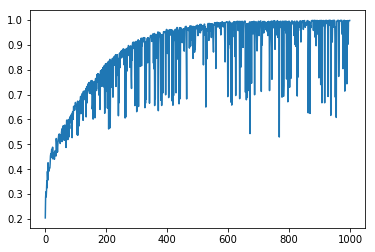

loss graph


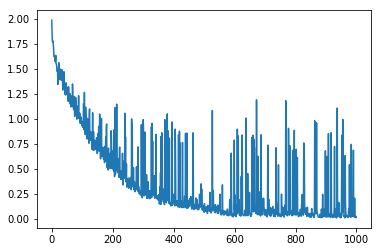

In [9]:
"""first task"""
print("First task started...")
loss_graph=[]
acc_graph=[]
iteration=[]
best_fitness1 = 0.0
gen = 0
first_fitness = []
#pathway 학습 
for gen in range(args.generation_limit):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.3)

    best_fitness1, best_path1, max_fitness1,loss,acc = train_pathnet(model,
                                                         gene,
                                                         cifar_train_loader,
                                                         best_fitness1,
                                                         best_path1,
                                                         gen,optimizer)
    
    first_fitness.append(max_fitness1)
    loss_graph.append(loss)
    acc_graph.append(acc)
    iteration.append(gen)
print("First task done!! Move to next task")


print("accuracy graph")
plt.plot(iteration,acc_graph)
plt.show()
print("loss graph")
plt.plot(iteration,loss_graph)
plt.show()


In [10]:
test_model(model,cifar_test_loader,best_path1)

Test Accuracy of the model on the test images: 43.47 %


In [11]:
print("Second task started...")
gene = Genetic(args.L, args.M, args.N, args.pop)
model.init(best_path1)
model=model.cuda()
#parameter set
trainable_params = []
params_set = [model.fc1, model.fc2, model.fc3]
for path, params in zip(best_path1, params_set):
    for i, param in enumerate(params):
        if  i in path:
            param.requires_grad = False
        else:
            p = {'params': param.parameters()}
            trainable_params.append(p)

p = {'params': model.final_layers.parameters()}
trainable_params.append(p)
optimizer = optim.Adam(trainable_params, lr=args.lr)

Second task started...


loss : 2.0416, acc : 0.1858
loss : 2.0669, acc : 0.2020
loss : 1.6811, acc : 0.2867
loss : 1.7614, acc : 0.2729
loss : 1.5650, acc : 0.3209
loss : 1.5253, acc : 0.3597
loss : 1.5092, acc : 0.4204
loss : 1.5509, acc : 0.3678
loss : 1.4820, acc : 0.4290
loss : 1.4539, acc : 0.4482
loss : 1.4906, acc : 0.3717
loss : 1.3523, acc : 0.4736
loss : 1.4081, acc : 0.4989
loss : 1.5010, acc : 0.4189
loss : 1.3299, acc : 0.5211
loss : 1.8124, acc : 0.3139
loss : 1.3806, acc : 0.4477
loss : 1.2320, acc : 0.4994
loss : 1.4301, acc : 0.4233
loss : 1.1920, acc : 0.5212
loss : 1.2619, acc : 0.5223
loss : 1.1910, acc : 0.5113
loss : 1.3158, acc : 0.5306
loss : 1.4697, acc : 0.4779
loss : 1.1918, acc : 0.5814
loss : 1.1951, acc : 0.5789
loss : 1.1914, acc : 0.6420
loss : 1.3006, acc : 0.5882
loss : 1.1096, acc : 0.6111
loss : 1.1610, acc : 0.5677
loss : 1.0338, acc : 0.5682
loss : 1.1271, acc : 0.5579
loss : 1.0944, acc : 0.6570
loss : 1.1942, acc : 0.5946
loss : 1.0707, acc : 0.6069
loss : 1.2823, acc :

loss : 0.2214, acc : 0.9258
loss : 0.2079, acc : 0.9268
loss : 0.2464, acc : 0.9162
loss : 0.2210, acc : 0.9251
loss : 0.2794, acc : 0.9235
loss : 0.2752, acc : 0.9280
loss : 0.2454, acc : 0.9277
loss : 0.4119, acc : 0.8332
loss : 0.2902, acc : 0.9140
loss : 0.2819, acc : 0.9266
loss : 0.2078, acc : 0.9264
loss : 0.2066, acc : 0.9274
loss : 0.2536, acc : 0.9079
loss : 0.3773, acc : 0.8512
loss : 0.1978, acc : 0.9171
loss : 0.2084, acc : 0.9242
loss : 0.2354, acc : 0.9273
loss : 0.2185, acc : 0.9293
loss : 0.2739, acc : 0.9153
loss : 0.2608, acc : 0.9189
loss : 0.1835, acc : 0.9268
loss : 0.1908, acc : 0.9307
loss : 0.2670, acc : 0.9296
loss : 0.2714, acc : 0.9201
loss : 0.2760, acc : 0.9291
loss : 0.2675, acc : 0.9288
loss : 0.2760, acc : 0.9265
loss : 0.2635, acc : 0.9252
loss : 0.1964, acc : 0.9266
loss : 0.1883, acc : 0.9293
loss : 0.2144, acc : 0.9266
loss : 0.1922, acc : 0.9314
loss : 0.2273, acc : 0.9255
loss : 0.2115, acc : 0.9256
loss : 0.2269, acc : 0.9323
loss : 0.2365, acc :

loss : 0.1382, acc : 0.9618
loss : 0.1423, acc : 0.9584
loss : 0.0970, acc : 0.9623
loss : 0.5106, acc : 0.8070
loss : 0.1545, acc : 0.9462
loss : 0.3385, acc : 0.8676
loss : 0.3451, acc : 0.8457
loss : 0.1348, acc : 0.9283
loss : 0.1236, acc : 0.9551
loss : 0.1280, acc : 0.9548
loss : 0.0888, acc : 0.9586
loss : 0.1291, acc : 0.9463
loss : 0.1617, acc : 0.9532
loss : 0.1538, acc : 0.9618
loss : 0.1189, acc : 0.9628
loss : 0.1220, acc : 0.9527
loss : 0.1221, acc : 0.9568
loss : 0.3002, acc : 0.8740
loss : 0.1464, acc : 0.9543
loss : 0.1380, acc : 0.9658
loss : 0.1342, acc : 0.9651
loss : 0.1279, acc : 0.9653
loss : 0.0987, acc : 0.9628
loss : 0.0848, acc : 0.9627
loss : 0.1010, acc : 0.9646
loss : 0.0997, acc : 0.9650
loss : 0.1056, acc : 0.9605
loss : 0.0966, acc : 0.9623
loss : 0.1281, acc : 0.9614
loss : 0.1269, acc : 0.9603
loss : 0.0994, acc : 0.9627
loss : 0.3587, acc : 0.8450
loss : 0.1399, acc : 0.9445
loss : 0.1211, acc : 0.9585
loss : 0.1198, acc : 0.9645
loss : 0.1144, acc :

loss : 0.1671, acc : 0.9545
loss : 0.1397, acc : 0.9698
loss : 0.1209, acc : 0.9689
loss : 0.1077, acc : 0.9723
loss : 0.1206, acc : 0.9707
loss : 0.1100, acc : 0.9701
loss : 0.1332, acc : 0.9589
loss : 0.1088, acc : 0.9702
loss : 0.0988, acc : 0.9712
loss : 0.0977, acc : 0.9703
loss : 0.1195, acc : 0.9672
loss : 0.1444, acc : 0.9466
loss : 0.3541, acc : 0.8705
loss : 0.1120, acc : 0.9526
loss : 0.0616, acc : 0.9733
loss : 0.0579, acc : 0.9753
loss : 0.0972, acc : 0.9761
loss : 0.0895, acc : 0.9746
loss : 0.3369, acc : 0.8753
loss : 0.3436, acc : 0.8831
loss : 0.0915, acc : 0.9632
loss : 0.0715, acc : 0.9734
loss : 0.1011, acc : 0.9755
loss : 0.3561, acc : 0.8655
loss : 0.1021, acc : 0.9554
loss : 0.0786, acc : 0.9741
loss : 0.0991, acc : 0.9652
loss : 0.3489, acc : 0.8331
loss : 0.1199, acc : 0.9445
loss : 0.2620, acc : 0.8976
loss : 0.1252, acc : 0.9527
loss : 0.0909, acc : 0.9704
loss : 0.1337, acc : 0.9713
loss : 0.4211, acc : 0.8776
loss : 0.1090, acc : 0.9643
loss : 0.4420, acc :

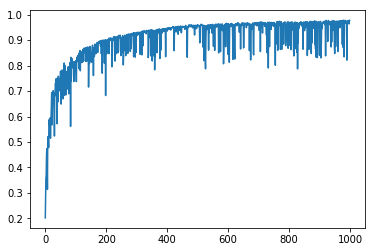

loss graph


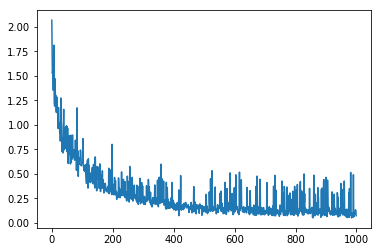

In [12]:
loss_graph=[]
acc_graph=[]
iteration=[]


best_fitness2 = 0.0    
best_path2 = [[None] * args.N] * args.L
gen = 0
second_fitness = []
for gen in range(args.generation_limit):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.3)

    best_fitness2, best_path2, max_fitness2 ,loss,acc= train_pathnet(model,
                                                         gene,
                                                         svhn_train_loader,
                                                         best_fitness2,
                                                         best_path2,
                                                         gen,optimizer)
    second_fitness.append(max_fitness2)
    loss_graph.append(loss)
    acc_graph.append(acc)
    iteration.append(gen)
    
print("Second task done!! Goodbye!!")

print("accuracy graph")
plt.plot(iteration,acc_graph)
plt.show()
print("loss graph")
plt.plot(iteration,loss_graph)
plt.show()

In [13]:
test_model(model,svhn_test_loader,best_path2)

Test Accuracy of the model on the test images: 81.31914566687155 %


In [14]:
result=[]
result.append(best_path1)
result.append(best_path2)
np.save("result/result_cifar_svhn_reduce_sum.npy",result)
torch.save(model.state_dict(), "result/cifar_svhn_reduce_sum_model.ckpt")

In [15]:
def load_and_test(cifar_test_loader,svhn_test_loader):
    #load data and test
    result=np.load("result/result_cifar_svhn_reduce_sum.npy")

    model=Net(args)
    model.load_state_dict(torch.load("result/cifar_svhn_reduce_sum_model.ckpt"))
    model=model.cuda()

    test_model(model,cifar_test_loader,result[0])
    test_model(model,svhn_test_loader,result[1])


In [3]:
from raf_dataset import *
train_data=["D:/emotion_dataset/RAF_Face_Database/basic/train_image_dir.npy","D:/emotion_dataset/RAF_Face_Database/basic/train_label.npy"]
raf_train_dataset=ImageDataset(fnames=train_data,transform=ToTensor())
raf_train_loader=torch.utils.data.DataLoader(dataset=raf_train_dataset,
                                           batch_size=args.batch_size, 
                                           shuffle=True)
test_data=["D:/emotion_dataset/RAF_Face_Database/basic/test_image_dir.npy","D:/emotion_dataset/RAF_Face_Database/basic/test_label.npy"]
raf_test_dataset=ImageDataset(fnames=test_data,transform=ToTensor())
raf_test_loader=torch.utils.data.DataLoader(dataset=raf_test_dataset,
                                           batch_size=args.batch_size, 
                                           shuffle=True)

emotion task started...
loss : 2.0274, acc : 0.1786
loss : 1.7934, acc : 0.3889
loss : 1.7806, acc : 0.3332
loss : 1.7184, acc : 0.3892
loss : 1.7871, acc : 0.1987
loss : 1.6604, acc : 0.3824
loss : 1.6720, acc : 0.3864
loss : 1.6833, acc : 0.3329
loss : 1.7122, acc : 0.3853
loss : 1.6959, acc : 0.3892
loss : 1.6926, acc : 0.3656
loss : 1.6409, acc : 0.3577
loss : 1.6319, acc : 0.3904
loss : 1.7224, acc : 0.3392
loss : 1.7305, acc : 0.2679
loss : 1.6466, acc : 0.3479
loss : 1.6893, acc : 0.2951
loss : 1.6747, acc : 0.3888
loss : 1.6226, acc : 0.3894
loss : 1.6252, acc : 0.3889
loss : 1.6404, acc : 0.3930
loss : 1.6371, acc : 0.3897
loss : 1.6945, acc : 0.2491
loss : 1.6684, acc : 0.2552
loss : 1.6685, acc : 0.3895
loss : 1.6547, acc : 0.3884
loss : 1.6238, acc : 0.3874
loss : 1.6246, acc : 0.3889
loss : 1.6421, acc : 0.3882
loss : 1.6283, acc : 0.3890
loss : 1.5963, acc : 0.3493
loss : 1.6069, acc : 0.3888
loss : 1.6594, acc : 0.3888
loss : 1.6793, acc : 0.2984
loss : 1.6882, acc : 0.3

loss : 1.2338, acc : 0.5592
loss : 1.2528, acc : 0.5106
loss : 1.2764, acc : 0.5246
loss : 1.1958, acc : 0.5524
loss : 1.2008, acc : 0.5454
loss : 1.3399, acc : 0.5283
loss : 1.3229, acc : 0.5298
loss : 1.1712, acc : 0.5563
loss : 1.1668, acc : 0.5565
loss : 1.1869, acc : 0.5194
loss : 1.2563, acc : 0.5217
loss : 1.2080, acc : 0.5564
loss : 1.1774, acc : 0.5668
loss : 1.1159, acc : 0.5750
loss : 1.1107, acc : 0.5713
loss : 1.2319, acc : 0.5053
loss : 1.1877, acc : 0.5525
loss : 1.2316, acc : 0.5282
loss : 1.2300, acc : 0.5340
loss : 1.2387, acc : 0.5510
loss : 1.2794, acc : 0.5365
loss : 1.2416, acc : 0.5399
loss : 1.1676, acc : 0.5675
loss : 1.3174, acc : 0.5379
loss : 1.2679, acc : 0.5694
loss : 1.3194, acc : 0.4987
loss : 1.2559, acc : 0.5403
loss : 1.2046, acc : 0.5598
loss : 1.2639, acc : 0.5313
loss : 1.1906, acc : 0.5733
loss : 1.1963, acc : 0.5737
loss : 1.1987, acc : 0.5743
loss : 1.2877, acc : 0.5358
loss : 1.1508, acc : 0.5674
loss : 1.2293, acc : 0.5349
loss : 1.4846, acc :

loss : 1.0083, acc : 0.6200
loss : 1.0643, acc : 0.6243
loss : 1.0622, acc : 0.6298
loss : 1.0120, acc : 0.6304
loss : 1.0044, acc : 0.6279
loss : 0.9988, acc : 0.6259
loss : 0.9849, acc : 0.6335
loss : 1.0040, acc : 0.6306
loss : 1.0484, acc : 0.6189
loss : 1.4555, acc : 0.4881
loss : 1.0952, acc : 0.6126
loss : 1.0311, acc : 0.6227
loss : 1.0251, acc : 0.6295
loss : 1.3299, acc : 0.4300
loss : 1.0580, acc : 0.5746
loss : 1.0816, acc : 0.5762
loss : 1.0159, acc : 0.6131
loss : 1.0835, acc : 0.6219
loss : 1.0579, acc : 0.6161
loss : 1.0222, acc : 0.6250
loss : 1.0204, acc : 0.6290
loss : 1.0265, acc : 0.6318
loss : 1.0321, acc : 0.6286
loss : 1.0664, acc : 0.6136
loss : 1.0522, acc : 0.6255
loss : 1.0259, acc : 0.6268
loss : 1.0121, acc : 0.6318
loss : 1.0750, acc : 0.6216
loss : 1.2266, acc : 0.5158
loss : 1.0571, acc : 0.6030
loss : 1.0201, acc : 0.6088
loss : 1.0072, acc : 0.6104
loss : 1.0542, acc : 0.6079
loss : 1.0168, acc : 0.6232
loss : 0.9986, acc : 0.6237
loss : 1.0162, acc :

loss : 0.9444, acc : 0.6293
loss : 1.0529, acc : 0.6273
loss : 1.0011, acc : 0.6424
loss : 0.9462, acc : 0.6525
loss : 1.0768, acc : 0.6066
loss : 1.0294, acc : 0.6252
loss : 1.1329, acc : 0.5964
loss : 0.9491, acc : 0.6526
loss : 0.9578, acc : 0.6471
loss : 0.9373, acc : 0.6504
loss : 1.2195, acc : 0.5502
loss : 1.0768, acc : 0.5893
loss : 0.9344, acc : 0.6379
loss : 0.9968, acc : 0.6285
loss : 0.9292, acc : 0.6486
loss : 0.9661, acc : 0.6531
loss : 1.0036, acc : 0.6277
loss : 1.1040, acc : 0.6218
loss : 1.0004, acc : 0.6488
loss : 1.2081, acc : 0.4407
loss : 1.0043, acc : 0.6191
loss : 1.0615, acc : 0.6237
loss : 1.0609, acc : 0.6203
loss : 1.0872, acc : 0.6278
loss : 1.0676, acc : 0.6301
loss : 1.3805, acc : 0.3692
loss : 1.3005, acc : 0.5398
loss : 1.0325, acc : 0.6207
loss : 0.9995, acc : 0.6297
loss : 0.9589, acc : 0.6232
loss : 0.9457, acc : 0.6374
loss : 0.9331, acc : 0.6495
loss : 0.9239, acc : 0.6477
loss : 0.9804, acc : 0.6386
loss : 0.9738, acc : 0.6505
loss : 0.9744, acc :

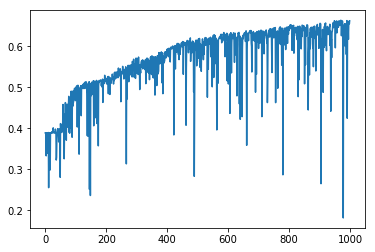

loss graph


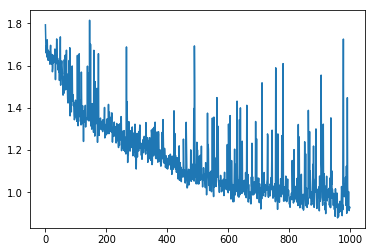

In [17]:
print("emotion task started...")
gene = Genetic(args.L, args.M, args.N, args.pop)
model.init(best_path2)
model.cuda()
#parameter set
trainable_params = []
params_set = [model.fc1, model.fc2, model.fc3]
for path, params in zip(best_path2, params_set):
    for i, param in enumerate(params):
        if  i in path:
            param.requires_grad = False
        else:
            p = {'params': param.parameters()}
            trainable_params.append(p)
            
p = {'params': model.final_layers.parameters()}
trainable_params.append(p)
optimizer = optim.Adam(trainable_params, lr=args.lr)


loss_graph=[]
acc_graph=[]
iteration=[]


best_fitness3 = 0.0    
best_path3 = [[None] * args.N] * args.L
gen = 0
second_fitness = []
for gen in range(args.generation_limit):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.3)

    best_fitness3, best_path3, max_fitness3 ,loss,acc= train_pathnet(model,
                                                         gene,
                                                         raf_train_loader,
                                                         best_fitness3,
                                                         best_path3,
                                                         gen,optimizer)
    second_fitness.append(max_fitness3)
    loss_graph.append(loss)
    acc_graph.append(acc)
    iteration.append(gen)
    
print("emotion task done!! Goodbye!!")

print("accuracy graph")
plt.plot(iteration,acc_graph)
plt.show()
print("loss graph")
plt.plot(iteration,loss_graph)
plt.show()

In [18]:
test_model(model,raf_test_loader,best_path3)

Test Accuracy of the model on the test images: 62.1251629726206 %


In [19]:
result=[]
result.append(best_path3)
np.save("result/meta_tranfer_emotion.npy",result)
torch.save(model.state_dict(), "result/meta_tranfer_emotion.ckpt")